In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten


2024-04-08 22:14:52.821913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 22:14:52.822128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 22:14:53.017837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load train and test metadata
train_metadata = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")
test_metadata = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/test.csv")


In [3]:
# Load sample submission file
sample_submission = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")


In [4]:
# Load train EEG data and spectrograms
train_eegs = pd.read_parquet("/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1000913311.parquet")
train_spectrograms = pd.read_parquet("/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/1000086677.parquet")




In [5]:
# Load test EEG data and spectrograms
test_eegs = pd.read_parquet("/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/3911565283.parquet")
test_spectrograms = pd.read_parquet("/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/853520.parquet")

In [6]:
# Exploration
print("Train Metadata Shape:", train_metadata.shape)


Train Metadata Shape: (106800, 15)


In [7]:
# Check the first few rows of the data
train_metadata.head()


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [8]:
print("Test Metadata Shape:", test_metadata.shape)


Test Metadata Shape: (1, 3)


In [9]:
# Check the first few rows of the data
test_metadata.head()



,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [10]:
print("Sample Submission Shape:", sample_submission.shape)


Sample Submission Shape: (1, 7)


In [11]:
# Check the first few rows of the data
sample_submission.head()


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667


In [12]:
print("Train EEGs Shape:", train_eegs.shape)


Train EEGs Shape: (10000, 20)


In [13]:
# Check the first few rows of the train_eegs data
train_eegs.head()


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-105.849998,-89.230003,-79.459999,-49.230000,-99.730003,-87.769997,-53.330002,-50.740002,-32.250000,-42.099998,-43.270000,-88.730003,-74.410004,-92.459999,-58.930000,-75.739998,-59.470001,8.210000,66.489998,1404.930054
1,-85.470001,-75.070000,-60.259998,-38.919998,-73.080002,-87.510002,-39.680000,-35.630001,-76.839996,-62.740002,-43.040001,-68.629997,-61.689999,-69.320000,-35.790001,-58.900002,-41.660000,196.190002,230.669998,3402.669922
2,8.840000,34.849998,56.430000,67.970001,48.099998,25.350000,80.250000,48.060001,6.720000,37.880001,61.000000,16.580000,55.060001,45.020000,70.529999,47.820000,72.029999,-67.180000,-171.309998,-3565.800049
3,-56.320000,-37.279999,-28.100000,-2.820000,-43.430000,-35.049999,3.910000,-12.660000,8.650000,3.830000,4.180000,-51.900002,-21.889999,-41.330002,-11.580000,-27.040001,-11.730000,-91.000000,-81.190002,-1280.930054
4,-110.139999,-104.519997,-96.879997,-70.250000,-111.660004,-114.430000,-71.830002,-61.919998,-76.150002,-79.779999,-67.480003,-99.029999,-93.610001,-104.410004,-70.070000,-89.250000,-77.260002,155.729996,264.850006,4325.370117


In [14]:
print("Train Spectrograms Shape:", train_spectrograms.shape)


Train Spectrograms Shape: (300, 401)


In [15]:
train_spectrograms.head()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,28.680000,53.990002,67.629997,59.880001,50.880001,74.309998,78.480003,63.080002,59.869999,...,0.13,0.14,0.08,0.11,0.04,0.03,0.05,0.05,0.04,0.05
1,3,29.639999,38.959999,44.009998,66.800003,48.509998,42.180000,47.340000,48.599998,40.880001,...,0.15,0.13,0.08,0.08,0.07,0.06,0.07,0.06,0.06,0.06
2,5,8.890000,9.020000,16.360001,23.559999,27.340000,30.040001,27.559999,23.290001,15.120000,...,0.12,0.11,0.08,0.08,0.09,0.10,0.12,0.14,0.13,0.14
3,7,1.770000,1.930000,1.810000,1.600000,1.430000,1.280000,1.190000,1.110000,1.010000,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04
4,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
print("Test EEGs Shape:", test_eegs.shape)


Test EEGs Shape: (10000, 20)


In [17]:
test_eegs.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,9.210000,-47.459999,15.100000,8.22,-16.900000,-22.99,-25.820000,-10.09,28.370001,-3.01,-27.299999,101.040001,35.110001,14.54,18.33,28.540001,44.090000,69.650002,30.74,171.679993
1,-3.590000,-30.290001,32.380001,10.80,-68.980003,-21.60,-15.080000,-9.21,26.360001,-8.98,-32.279999,95.800003,26.389999,4.82,10.54,20.559999,32.060001,59.439999,23.32,178.279999
2,-26.040001,-60.070000,2.370000,-10.15,-34.689999,-31.40,-31.920000,-26.98,-1.940000,-28.77,-49.770000,73.449997,-3.680000,-17.32,-16.15,-8.270000,5.330000,45.180000,9.49,306.739990
3,-3.040000,-36.250000,29.559999,14.53,-14.010000,-11.90,-14.230000,-6.31,26.040001,-2.77,-25.030001,91.010002,22.610001,6.90,9.93,15.480000,33.580002,69.620003,31.01,223.259995
4,-4.630000,-20.160000,25.190001,1.19,-44.580002,-23.51,-30.709999,-17.60,25.420000,-8.86,-33.959999,89.449997,19.440001,-2.08,6.11,8.380000,24.180000,55.869999,19.91,170.759995


In [18]:
print("Test Spectrograms Shape:", test_spectrograms.shape)

Test Spectrograms Shape: (300, 401)


In [19]:
test_spectrograms.head()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,14.910000,17.110001,11.660000,11.73,6.08,4.54,4.31,3.38,2.05,...,0.07,0.06,0.05,0.06,0.05,0.05,0.06,0.05,0.04,0.05
1,3,11.130000,10.950000,10.770000,5.07,4.03,3.24,3.61,2.98,1.54,...,0.05,0.04,0.04,0.04,0.04,0.04,0.03,0.03,0.03,0.02
2,5,10.880000,10.570000,8.790000,5.33,2.44,1.48,1.83,0.99,0.89,...,0.04,0.04,0.04,0.03,0.03,0.04,0.04,0.05,0.06,0.06
3,7,19.450001,18.200001,17.719999,13.38,4.17,1.88,1.84,1.22,1.27,...,0.03,0.03,0.05,0.08,0.07,0.07,0.08,0.03,0.03,0.03
4,9,21.650000,22.530001,23.160000,17.00,7.19,3.89,3.65,2.72,2.35,...,0.04,0.04,0.05,0.05,0.06,0.05,0.05,0.05,0.04,0.03


In [20]:
# Check for missing values
print("Missing values in train metadata:", train_metadata.isnull().sum().sum())
print("Missing values in train eegs:", train_eegs.isnull().sum().sum())
print("Missing values in train spectrograms:", train_spectrograms.isnull().sum().sum())


Missing values in train metadata: 0
Missing values in train eegs: 0
Missing values in train spectrograms: 10400


In [21]:
# Data Processing and Cleaning
# Drop irrelevant columns from metadata
train_metadata = train_metadata.drop(columns=['eeg_sub_id', 'eeg_label_offset_seconds',
                                              'spectrogram_sub_id', 'spectrogram_label_offset_seconds',
                                              'label_id', 'patient_id'])
test_metadata = test_metadata.drop(columns=['eeg_id', 'patient_id'])

In [22]:
# Merge train metadata with corresponding EEG data
train_data = pd.concat([train_metadata, train_eegs], axis=1)


In [23]:
# Merge test metadata with corresponding EEG data
test_data = pd.concat([test_metadata, test_eegs], axis=1)


In [24]:
# Drop any NaN values
train_data = train_data.dropna()
test_data = test_data.dropna()
train_spectrograms = train_spectrograms.dropna()

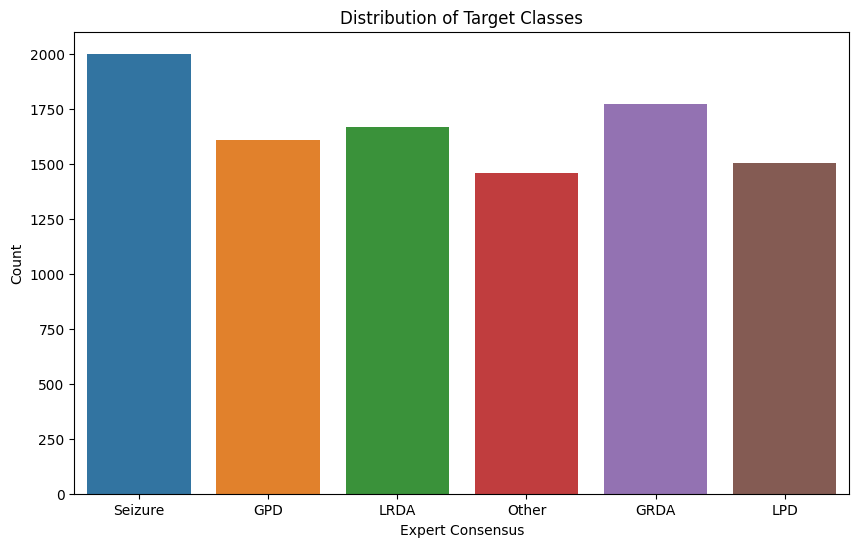

In [25]:
# Data Visualization
# Plot the distribution of target classes in the training data
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='expert_consensus')
plt.title("Distribution of Target Classes")
plt.xlabel("Expert Consensus")
plt.ylabel("Count")
plt.show()

In [26]:
# Feature Scaling
# Separate features and target variable
X = train_data.drop(columns=['expert_consensus'])
y = train_data['expert_consensus']

In [27]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [29]:
# Model Building and Evaluation
# Define a CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [30]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [31]:
# Reshape data for CNN
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_cnn = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))


In [32]:
# Convert target variable into numerical format
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)



In [33]:
# Fit the model
cnn_model.fit(X_train_cnn, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val_cnn, y_val_encoded))


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1784 - loss: -845.9052 - val_accuracy: 0.1725 - val_loss: -14299.8291
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1761 - loss: -30986.9570 - val_accuracy: 0.1725 - val_loss: -126754.3750
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1802 - loss: -182643.1250 - val_accuracy: 0.1725 - val_loss: -426453.7500
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1898 - loss: -530363.7500 - val_accuracy: 0.1725 - val_loss: -982265.7500
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1711 - loss: -1167098.0000 - val_accuracy: 0.1725 - val_loss: -1842419.1250
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1732 - loss: -2054473.7500 - val_accuracy: 0.1725 - val_loss: -3057705.0000
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1764 - loss: -3414341.5000 - val_accuracy: 0.1725 - val_loss: -4645283.5000
Epoch 8/10
250/250 

In [34]:
# Predict probabilities for each class
y_prob_cnn = cnn_model.predict(X_val_cnn)

# Convert probabilities to predicted class labels
y_pred_cnn = np.argmax(y_prob_cnn, axis=1)

# Calculate accuracy
accuracy_cnn = accuracy_score(y_val_encoded, y_pred_cnn)
print("CNN Model Accuracy:", accuracy_cnn)



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
CNN Model Accuracy: 0.158


In [35]:
from sklearn.preprocessing import LabelBinarizer

# Binarize the target labels
label_binarizer = LabelBinarizer()
y_train_binary = label_binarizer.fit_transform(y_train)
y_val_binary = label_binarizer.transform(y_val)


In [36]:

# Define an LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_scaled.shape[1], 1)),
    Dense(y_train_binary.shape[1], activation='sigmoid')  # Output layer with sigmoid activation
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
lstm_model.fit(X_train_cnn, y_train_binary, epochs=10, batch_size=32, validation_data=(X_val_cnn, y_val_binary))


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1760 - loss: 0.5194 - val_accuracy: 0.2095 - val_loss: 0.4500
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1866 - loss: 0.4503 - val_accuracy: 0.2090 - val_loss: 0.4489
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.1952 - loss: 0.4496 - val_accuracy: 0.1745 - val_loss: 0.4505
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1900 - loss: 0.4495 - val_accuracy: 0.1755 - val_loss: 0.4497
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.1917 - loss: 0.4496 - val_accuracy: 0.1935 - val_loss: 0.4495
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2275 - loss: 0.4444 - val_accuracy: 0.4120 - val_loss: 0.3861
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4579 - loss: 0.3507 - val_accuracy: 0.6155 - val_loss: 0.2600
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6593 - loss: 0.2603 - val_accu

In [38]:
# Predict probabilities
y_prob_lstm = lstm_model.predict(X_val_cnn)

# Convert probabilities to binary classes
y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

# Evaluate accuracy
accuracy_lstm = accuracy_score(y_val_binary, y_pred_lstm)
print("LSTM Model Accuracy:", accuracy_lstm)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
LSTM Model Accuracy: 0.8725


In [39]:
# Submission DataFrame without test data prediction
submission_df = pd.DataFrame({
    'lpd_vote': [0.166667],
    'gpd_vote': [0.166667],
    'lrda_vote': [0.166667],
    'grda_vote': [0.166667],
    'other_vote': [0.166667]
})

# Save submission to CSV
submission_df.to_csv('submission.csv', index=False)

